<center><h1> Iconic Customer Categorisation </h1></center>

It’s helpful if we can suggest an approximate salary to job seekers
for a given job post.
<br>
<b>The goal: provide estimated salaries for a new job posting<b>

In [ ]:
### Uncomment to install requirements
#!pip install -r requirements.txt

<u><b>Important Note</b></u> - 
If you re-run this code, KMeans cluster lables may change. This will need re-interpreting accompanied DOCX file.

Find the document for explanation at [Report.docx](Report.docx) <br>
For model selection code should be run to find optimal hyper-params [select.py](model_selection/autoencoder/select.py) <br>
For model selection hyper-parameter ranges should be set in [config.yaml](model_selection/autoencoder/config.yaml) <br>
Best hyper-parameters for the Autoencoder will get saved in [performance.log](model_selection/autoencoder/performance.log) 
<br>
SQL Queries are at [queries.sql](sqllite/queries.sql) 

In [2]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import numpy as np
import tensorflow as tf
import random as python_random
import pandas_profiling as pp
from scipy.stats import describe
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import math

%matplotlib inline

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

!export PYTHONHASHSEED=0

## Reading the dataset

Given input data has one json data files:

In [2]:
df = pd.read_json('data/raw/data.json',  lines=True)

In [3]:
df.shape

(46279, 43)

## Summary

Basic idea about the dataset can be obtained by visualising, looking at the description and the information. The easiest way 
would be to use pandas profiling tool. 

In [4]:
df.head()

sacc_items  work_orders  female_items is_newsletter_subscriber  male_items  \
0  0           0            46            N                        2            
1  0           0            24            Y                        0            
2  0           0            147           Y                        3            
3  0           0            0             Y                        0            
4  0           0            1             Y                        0            

   afterpay_payments  msite_orders  wftw_items  mapp_items  orders  \
0  0                  0             7           2           17       
1  0                  12            2           0           13       
2  1                  10            33          2           71       
3  0                  0             0           1           2        
4  0                  0             1           0           1        

   cc_payments  curvy_items  paypal_payments  macc_items  cancels   revenue  \
0  1            0            0                1           0        6946.34    
1  0            0            1                4           0        5329.28    
2  1            0            0                17          2        14133.87   
3  1            0            0                0           0        143.64     
4  1            0            0                0           0        0.00       

   returns  other_collection_orders  parcelpoint_orders  \
0  1        16                       0                    
1  5        4                        0                    
2  2        60                       0                    
3  0        2                        0                    
4  0        1                        0                    

                        customer_id  android_orders  days_since_last_order  \
0  64f7d7dd7a59bba7168cc9c960a5c60e  0               15672                   
1  fa7c64efd5c037ff2abcce571f9c1712  0               528                     
2  18923c9361f27583d2320951435e4888  0               144                     
3  aa21f31def4edbdcead818afcdfc4d32  0               49200                   
4  668c6aac52ff54d4828ad379cdb38e7d  0               49272                   

   vouchers  average_discount_used  shipping_addresses  redpen_discount_used  \
0  3         3584.4818              4                   4554.39                
1  0         1404.0966              4                   629.03                 
2  3         1899.7270              6                   6269.71                
3  1         3875.6715              1                   0.00                   
4  0         0.0000                 1                   0.00                   

   mftw_items  days_since_first_order  unisex_items  home_orders  \
0  0           2091                    2             1             
1  0           2082                    2             9             
2  0           2072                    2             11            
3  0           2054                    2             0             
4  0           2053                    0             0             

   coupon_discount_applied  desktop_orders  ios_orders  apple_payments  \
0  248.65                   17              0           0                
1  0.00                     1               0           0                
2  107.92                   61              0           0                
3  90.90                    2               0           0                
4  0.00                     1               0           0                

   wspt_items  wacc_items  items  mspt_items  devices  different_addresses  \
0  4           1           50     0           1        0                     
1  3           4           26     0           2        0                     
2  3           17          152    0           2        1                     
3  0           0           2      0           1        0                     
4  0           0           1      0           1        0               

In [5]:
df.describe()

sacc_items   work_orders  female_items    male_items  \
count  46279.000000  46279.000000  46279.000000  46279.000000   
mean   0.087642      0.239785      6.465827      1.719203       
std    0.538434      1.560983      17.805349     5.464658       
min    0.000000      0.000000      0.000000      0.000000       
25%    0.000000      0.000000      0.000000      0.000000       
50%    0.000000      0.000000      2.000000      0.000000       
75%    0.000000      0.000000      5.000000      1.000000       
max    29.000000     84.000000     537.000000    273.000000     

       afterpay_payments  msite_orders    wftw_items    mapp_items  \
count  46279.000000       46279.000000  46279.000000  46279.000000   
mean   0.053437           0.978133      1.633333      0.927094       
std    0.224905           2.855797      4.084444      3.693033       
min    0.000000           0.000000      0.000000      0.000000       
25%    0.000000           0.000000      0.000000      0.000000       
50%    0.000000           0.000000      0.000000      0.000000       
75%    0.000000           1.000000      2.000000      0.000000       
max    1.000000           172.000000    261.000000    151.000000     

             orders   cc_payments   curvy_items  paypal_payments  \
count  46279.000000  46279.000000  46279.000000  46279.000000      
mean   4.108213      0.642386      0.041423      0.490914          
std    8.115099      0.479303      0.782021      0.499923          
min    1.000000      0.000000      0.000000      0.000000          
25%    1.000000      0.000000      0.000000      0.000000          
50%    2.000000      1.000000      0.000000      0.000000          
75%    4.000000      1.000000      0.000000      1.000000          
max    665.000000    1.000000      116.000000    1.000000          

         macc_items       cancels        revenue       returns  \
count  46279.000000  46279.000000  46279.000000   46279.000000   
mean   0.573565      0.053091      1303.695708    1.622312       
std    2.538707      2.169831      5599.989015    7.006281       
min    0.000000      0.000000      0.000000       0.000000       
25%    0.000000      0.000000      76.340000      0.000000       
50%    0.000000      0.000000      212.670000     0.000000       
75%    0.000000      0.000000      790.500000     1.000000       
max    353.000000    460.000000    354700.160000  343.000000     

       other_collection_orders  parcelpoint_orders  android_orders  \
count  46279.000000             46279.000000        46279.000000     
mean   2.310962                 0.025281            0.042935         
std    5.185966                 0.451226            0.535762         
min    0.000000                 0.000000            0.000000         
25%    1.000000                 0.000000            0.000000         
50%    1.000000                 0.000000            0.000000         
75%    2.000000                 0.000000            0.000000         
max    665.000000               32.000000           33.000000        

       days_since_last_order      vouchers  average_discount_used  \
count  46279.000000           46279.000000  46279.000000            
mean   24592.675382           0.940275      2357.381799             
std    16935.826675           2.413117      2033.075229             
min    24.000000              0.000000      0.000000                
25%    6816.000000            0.000000      83.883000               
50%    25560.000000           0.000000      2122.648100             
75%    41640.000000           1.000000      3829.882950             
max    51840.000000           57.000000     10000.000000            

       shipping_addresses  redpen_discount_used    mftw_items  \
count  46279.000000        46279.000000          46279.000000   
mean   1.500940            435.216546            0.420126       
std    1.098283            1849.462559           1.441323       
min    1.000000            0.000000              0.000000       
25%   

In [6]:
df.isna().any()

sacc_items                  False
work_orders                 False
female_items                False
is_newsletter_subscriber    False
male_items                  False
afterpay_payments           False
msite_orders                False
wftw_items                  False
mapp_items                  False
orders                      False
cc_payments                 False
curvy_items                 False
paypal_payments             False
macc_items                  False
cancels                     False
revenue                     False
returns                     False
other_collection_orders     False
parcelpoint_orders          False
customer_id                 False
android_orders              False
days_since_last_order       False
vouchers                    False
average_discount_used       False
shipping_addresses          False
redpen_discount_used        False
mftw_items                  False
days_since_first_order      False
unisex_items                False
home_orders   

<b>Note</b> - There are some missing values for coupon_discount_applied. It can be filled with zeros, as this number is relatively small.
Also, in the SQL step if was identified that there are duplicates. Futher, is_newsletter_subscriber has characers which should be converted to numerical. Here we fix those 3 problems

In [7]:
df['is_newsletter_subscriber'] = df['is_newsletter_subscriber'].apply(lambda x : 1 if x=='Y' else 0)
df = df.drop_duplicates(keep='first')
df = df.fillna(0)

In [8]:
46279-df.shape[0]

249

In [9]:
df.to_csv('data/processed/encoded.csv', index=False)

## Initial analysis

This section does the basic statistical and visual analysis to understand the dataset. 

### Entire population

The following graph shows the salary details of the entire population

Text(0.5, 0.98, 'Revenue Distribution')

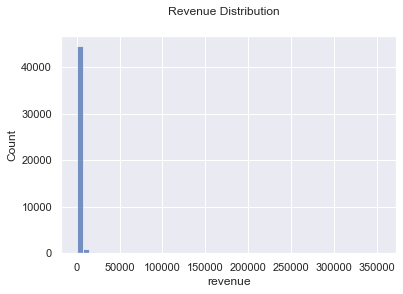

In [10]:
sns.histplot(bins=50, data=df, x="revenue")
plt.suptitle('Revenue Distribution')

In [11]:
df['revenue'].describe()

count    46030.000000 
mean     1305.479232  
std      5611.107402  
min      0.000000     
25%      76.360000    
50%      213.015000   
75%      791.870000   
max      354700.160000
Name: revenue, dtype: float64

<h4><u>Note</u></h4> The distribution of the revenue looks a bit un-realistic, especially at higher values. So first those values above IQR are removed

Also, it can be noted that the "days_since_last_order" and "days_since_first_order" are a bit messy as always "days_since_first_order" should be greater than "days_since_last_order". If we do this the number of remaining entries will be. 

In [12]:
print(df[df.days_since_last_order>=df.days_since_first_order].shape[0])

43372


## Data Cleansing

<h4><b><u>Note</u></b></h4> This suggests that these two column names are swapped. Here we dont fix the column name but instead select the entries in the otherway around.  

In [13]:
df  = df[df.days_since_last_order>=df.days_since_first_order].copy()
q25 = df.revenue.quantile(0.25)
q75 = df.revenue.quantile(0.75)
df  = df[df.revenue<=q75+1.5*(q75-q25)].copy()

To analys other features, it is easier if we ignore values with zero and check the distribution of other numbers as there are too many zeros.

In [14]:
for c in [c for c in df.columns if (c!='customer_id') | (c!='revenue')]:
    print('___________________________________________')
    print(c)
    print(df[df[c]!=df[c].min()][c].describe())
    print('\n')

___________________________________________
sacc_items
count    1190.000000
mean     1.441176   
std      1.080207   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      18.000000  
Name: sacc_items, dtype: float64


___________________________________________
work_orders
count    1742.000000
mean     1.865672   
std      1.841285   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      39.000000  
Name: work_orders, dtype: float64


___________________________________________
female_items
count    26953.000000
mean     3.196824    
std      3.599520    
min      1.000000    
25%      1.000000    
50%      2.000000    
75%      4.000000    
max      107.000000  
Name: female_items, dtype: float64


___________________________________________
is_newsletter_subscriber
count    13135.0
mean     1.0    
std      0.0    
min      1.0    
25%      1.0    
50%      1.0    
75%      1.0    
max      1.0    
Name: i

count    2670.000000
mean     1.734082   
std      1.639389   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      52.000000  
Name: wspt_items, dtype: float64


___________________________________________
wacc_items
count    6087.000000
mean     1.675209   
std      1.417746   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      32.000000  
Name: wacc_items, dtype: float64


___________________________________________
items
count    23616.000000
mean     4.903498    
std      4.744388    
min      2.000000    
25%      2.000000    
50%      3.000000    
75%      6.000000    
max      232.000000  
Name: items, dtype: float64


___________________________________________
mspt_items
count    1533.000000
mean     1.617743   
std      1.501522   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      25.000000  
Name: mspt_items, dtype: float64


_________________________

<h4><b><u>Note</u></b></h4> 
For most of the features, we can see that after 75th percentile, there are a few values which goes to very large numbers. Thos could be anomalies so we remove such points

In [15]:
cols = [c for c in df.columns if c!='customer_id']

Q1 = df[ df[cols]>0 ][cols].quantile(0.25)
Q3 = df[ df[cols]>0 ][cols].quantile(0.75)
IQR = Q3 - Q1


cutoff = Q3 + 1.5 * IQR + 1
cutoff = cutoff.apply(lambda x : math.ceil(x))

for c in cutoff.index:
    df = df[df[c]<cutoff[c]].copy()

In [18]:
df.to_csv('./data/processed/encoded.csv', index=False)

## Model Training

Still, the dataset can have outliers, one of the ways to remove outliers will be to use an Autoencoder. Here we use an Autoencoder
with 2 encoding layers.

In model training, the most important part is model selection by hyper-parameter tuning. To generate hyper-parameters,
configure the configuration script [model_selection/autoencoder/config.yaml](model_selection/autoencoder/config.yaml), 
and run hyper parameter tuning script in [model_selection/autoencoder/select.py](model_selection/autoencoder/select.py).

Here, we use selected hyper-parameters to train a model for outlier removal. 

### Autoencoder

In [20]:
labelling_steps = list()

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from utilities import AnomalyDetector


tdf = df[[c for c in df.columns if c!='customer_id']]

sc   = MinMaxScaler()
data = sc.fit_transform(tdf)
labelling_steps.append(sc)
train_data, test_data, _, _ = train_test_split(data, data[:,0], test_size=0.3, random_state=21)


autoencoder = AnomalyDetector()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')
history     = autoencoder.fit(  
                                train_data, 
                                train_data, 
                                epochs          = 500, 
                                batch_size      = 500,
                                validation_data = (test_data, test_data),
                                shuffle         = True
                            )

labelling_steps.append(autoencoder)
test_loss = autoencoder.evaluate(test_data, test_data)

Epoch 1/500
36/36 [==============================] - 1s 7ms/step - loss: 0.0686 - val_loss: 0.0657
Epoch 2/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0578
Epoch 3/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0478
Epoch 4/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0390
Epoch 5/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0336
Epoch 6/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.0304
Epoch 7/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0277
Epoch 8/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0268 - val_loss: 0.0252
Epoch 9/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0232
Epoch 10/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0215
Epoch 11/

36/36 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 84/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 85/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 86/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 87/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 88/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 89/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 90/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 91/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 92/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 93/500


36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 165/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 166/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 167/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 168/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 169/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 170/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 171/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 172/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 173/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoc

36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 246/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 247/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 248/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 249/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 250/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 251/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 252/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 253/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 254/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoc

36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 327/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 328/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 329/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 330/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 331/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 332/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 333/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 334/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 335/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0030
Epoc

36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 408/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 409/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 410/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 411/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 412/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 413/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 414/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 415/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 416/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoc

36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 489/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 490/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 491/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 492/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 493/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 494/500
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 495/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 496/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 497/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0030
Epoc

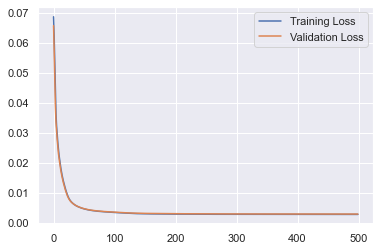

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

The predictions can be re-analysed by plotting them again as follows

In [23]:
rdf = pd.DataFrame( ( autoencoder.predict(data) ) )
rdf.columns = [c for c in df.columns if c!='customer_id']
rdf.shape

(25551, 42)

In [24]:
low_std = []

for c in [c for c in rdf.columns if (c!='customer_id') | (c!='revenue')]:
    print('___________________________________________')
    print(c)
    
    if(rdf[c].std()<1e-8):
        low_std.append(c)
        print('-- Low standard deviation -- ')
        
    #sns.histplot(data=rdf, x=c)
    #plt.show()
    print('\n')

___________________________________________
sacc_items
-- Low standard deviation -- 


___________________________________________
work_orders


___________________________________________
female_items


___________________________________________
is_newsletter_subscriber


___________________________________________
male_items


___________________________________________
afterpay_payments
-- Low standard deviation -- 


___________________________________________
msite_orders


___________________________________________
wftw_items


___________________________________________
mapp_items


___________________________________________
orders


___________________________________________
cc_payments


___________________________________________
curvy_items
-- Low standard deviation -- 


___________________________________________
paypal_payments


___________________________________________
macc_items


___________________________________________
cancels
-- Low standard deviation -- 



In [25]:
print('The number of columns with a low standard deviation : ', len(low_std))

The number of columns with a low standard deviation :  12


In [26]:
low_std

['sacc_items',
 'afterpay_payments',
 'curvy_items',
 'cancels',
 'parcelpoint_orders',
 'vouchers',
 'shipping_addresses',
 'apple_payments',
 'mspt_items',
 'devices',
 'different_addresses',
 'other_device_orders']

#### PCA

Text(0.5, 0.98, 'Cummulative Variance Ratio')

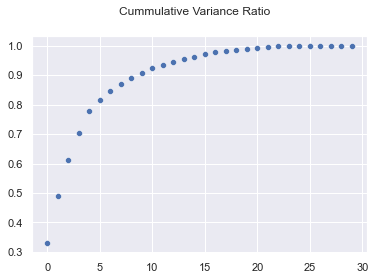

In [27]:
pca = PCA(rdf.shape[1]-len(low_std))
pca.fit(rdf)
labelling_steps.append(pca)

pcaratio = pca.explained_variance_ratio_
trace    = sns.scatterplot(x=np.arange(len(pcaratio)),y=np.cumsum(pcaratio))
plt.suptitle('Cummulative Variance Ratio')

### KMeans Clustering

Text(0.5, 1.0, 'Visualized on TSNE 2D')

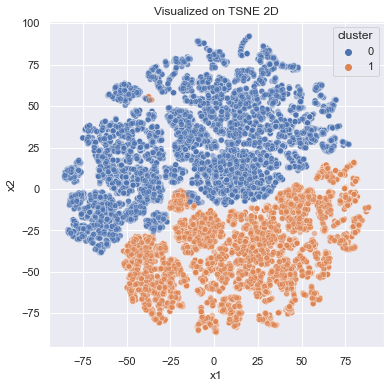

In [28]:
trdf = rdf.copy()

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(trdf)

labelling_steps.append(kmeans)

Xtsne = TSNE(n_components=2).fit_transform(trdf)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = labels
dftsne.columns = ['x1','x2','cluster']

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=dftsne, x='x1',y='x2', hue='cluster',legend="full",alpha=0.5,ax=ax)
ax.set_title('Visualized on TSNE 2D')

In [29]:
cc_df = pd.DataFrame(kmeans.cluster_centers_)
cc_df = pd.DataFrame( sc.inverse_transform((cc_df) ) )
cc_df.columns = rdf.columns
cc_df.head()

sacc_items  work_orders  female_items  is_newsletter_subscriber  \
0  0.0         0.054806     1.157273      0.352935                   
1  0.0         0.019359     1.143991      0.203466                   

   male_items  afterpay_payments  msite_orders  wftw_items  mapp_items  \
0  0.504807    0.0                0.283015      0.465796    0.206390     
1  0.533110    0.0                0.292847      0.488706    0.208837     

     orders  cc_payments  curvy_items  paypal_payments  macc_items  cancels  \
0  1.305062  0.958071     0.0          0.022084         0.154652    0.0       
1  1.276441  0.031836     0.0          0.998035         0.152891    0.0       

      revenue   returns  other_collection_orders  parcelpoint_orders  \
0  155.867889  0.189371  0.855412                 0.0                  
1  135.526016  0.183543  1.059785                 0.0                  

   android_orders  days_since_last_order  vouchers  average_discount_used  \
0  2.810290e-04    28900.074219           0.0       1964.443359             
1 -1.091394e-09    34049.222656           0.0       2355.417969             

   shipping_addresses  redpen_discount_used  mftw_items  \
0  1.0                 44.8951               0.173833     
1  1.0                 50.5355               0.150965     

   days_since_first_order  unisex_items  home_orders  coupon_discount_applied  \
0  1239.944580             0.176003      0.384702     7.752163                  
1  1458.949829             0.146032      0.191041     6.627780                  

   desktop_orders  ios_orders  apple_payments  wspt_items  wacc_items  \
0  0.960551        0.054482    0.0             0.070527    0.154734     
1  0.955956        0.024446    0.0             0.058772    0.153366     

      items  mspt_items  devices  different_addresses  wapp_items  \
0  1.830239  0.0         1.0      0.0                  0.456210     
1  1.816162  0.0         1.0      0.0                  0.393128     

   other_device_orders  average_discount_onoffer  
0  0.0                  0.164182                  
1  0.0                  0.206577

### Prediction accuracy

In [30]:
df['label'] = labels
tdf = df[[c for c in df.columns if c!='customer_id']]

df.to_csv('data/processed/labelled_inliers.csv', index=False)

Epoch 1/500
3/3 [==============================] - 3s 485ms/step - loss: 0.6977 - tp: 5139.0000 - fp: 6985.0000 - tn: 331.0000 - fn: 64.0000 - accuracy: 0.4369 - precision: 0.4239 - recall: 0.9877 - auc: 0.5312 - prc: 0.4005 - val_loss: 0.6887 - val_tp: 2201.0000 - val_fp: 2390.0000 - val_tn: 731.0000 - val_fn: 44.0000 - val_accuracy: 0.5464 - val_precision: 0.4794 - val_recall: 0.9804 - val_auc: 0.8133 - val_prc: 0.7264
Epoch 2/500
3/3 [==============================] - 0s 15ms/step - loss: 0.6862 - tp: 5090.0000 - fp: 4646.0000 - tn: 2670.0000 - fn: 113.0000 - accuracy: 0.6199 - precision: 0.5228 - recall: 0.9783 - auc: 0.8793 - prc: 0.8198 - val_loss: 0.6805 - val_tp: 2206.0000 - val_fp: 1052.0000 - val_tn: 2069.0000 - val_fn: 39.0000 - val_accuracy: 0.7967 - val_precision: 0.6771 - val_recall: 0.9826 - val_auc: 0.9636 - val_prc: 0.9546
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6783 - tp: 5126.0000 - fp: 1904.0000 - tn: 5412.0000 - fn: 77.0000 - accur

3/3 [==============================] - 0s 16ms/step - loss: 0.4207 - tp: 5203.0000 - fp: 193.0000 - tn: 7123.0000 - fn: 0.0000e+00 - accuracy: 0.9846 - precision: 0.9642 - recall: 1.0000 - auc: 0.9999 - prc: 0.9998 - val_loss: 0.4157 - val_tp: 2245.0000 - val_fp: 90.0000 - val_tn: 3031.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9832 - val_precision: 0.9615 - val_recall: 1.0000 - val_auc: 0.9999 - val_prc: 0.9998
Epoch 21/500
3/3 [==============================] - 0s 16ms/step - loss: 0.4138 - tp: 5203.0000 - fp: 181.0000 - tn: 7135.0000 - fn: 0.0000e+00 - accuracy: 0.9855 - precision: 0.9664 - recall: 1.0000 - auc: 0.9999 - prc: 0.9998 - val_loss: 0.4095 - val_tp: 2245.0000 - val_fp: 87.0000 - val_tn: 3034.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9838 - val_precision: 0.9627 - val_recall: 1.0000 - val_auc: 0.9999 - val_prc: 0.9999
Epoch 22/500
3/3 [==============================] - 0s 16ms/step - loss: 0.4081 - tp: 5203.0000 - fp: 173.0000 - tn: 7143.0000 - fn: 0.0000e+00 - accurac

3/3 [==============================] - 0s 16ms/step - loss: 0.3711 - tp: 5203.0000 - fp: 48.0000 - tn: 7268.0000 - fn: 0.0000e+00 - accuracy: 0.9962 - precision: 0.9909 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3690 - val_tp: 2245.0000 - val_fp: 27.0000 - val_tn: 3094.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9950 - val_precision: 0.9881 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 40/500
3/3 [==============================] - 0s 16ms/step - loss: 0.3699 - tp: 5203.0000 - fp: 52.0000 - tn: 7264.0000 - fn: 0.0000e+00 - accuracy: 0.9958 - precision: 0.9901 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3678 - val_tp: 2245.0000 - val_fp: 28.0000 - val_tn: 3093.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9948 - val_precision: 0.9877 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 41/500
3/3 [==============================] - 0s 16ms/step - loss: 0.3687 - tp: 5203.0000 - fp: 49.0000 - tn: 7267.0000 - fn: 0.0000e+00 - accuracy: 

3/3 [==============================] - 0s 15ms/step - loss: 0.3512 - tp: 5203.0000 - fp: 20.0000 - tn: 7296.0000 - fn: 0.0000e+00 - accuracy: 0.9984 - precision: 0.9962 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3496 - val_tp: 2245.0000 - val_fp: 16.0000 - val_tn: 3105.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9970 - val_precision: 0.9929 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 59/500
3/3 [==============================] - 0s 16ms/step - loss: 0.3502 - tp: 5203.0000 - fp: 20.0000 - tn: 7296.0000 - fn: 0.0000e+00 - accuracy: 0.9984 - precision: 0.9962 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3487 - val_tp: 2245.0000 - val_fp: 16.0000 - val_tn: 3105.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9970 - val_precision: 0.9929 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 60/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3493 - tp: 5203.0000 - fp: 20.0000 - tn: 7296.0000 - fn: 0.0000e+00 - accuracy: 

3/3 [==============================] - 0s 14ms/step - loss: 0.3345 - tp: 5203.0000 - fp: 18.0000 - tn: 7298.0000 - fn: 0.0000e+00 - accuracy: 0.9986 - precision: 0.9966 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3336 - val_tp: 2245.0000 - val_fp: 16.0000 - val_tn: 3105.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9970 - val_precision: 0.9929 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 78/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3337 - tp: 5203.0000 - fp: 16.0000 - tn: 7300.0000 - fn: 0.0000e+00 - accuracy: 0.9987 - precision: 0.9969 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3326 - val_tp: 2244.0000 - val_fp: 14.0000 - val_tn: 3107.0000 - val_fn: 1.0000 - val_accuracy: 0.9972 - val_precision: 0.9938 - val_recall: 0.9996 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 79/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3329 - tp: 5203.0000 - fp: 12.0000 - tn: 7304.0000 - fn: 0.0000e+00 - accuracy: 0.99

3/3 [==============================] - 0s 14ms/step - loss: 0.3194 - tp: 5203.0000 - fp: 9.0000 - tn: 7307.0000 - fn: 0.0000e+00 - accuracy: 0.9993 - precision: 0.9983 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3190 - val_tp: 2245.0000 - val_fp: 17.0000 - val_tn: 3104.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9968 - val_precision: 0.9925 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 97/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3187 - tp: 5203.0000 - fp: 7.0000 - tn: 7309.0000 - fn: 0.0000e+00 - accuracy: 0.9994 - precision: 0.9987 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3181 - val_tp: 2245.0000 - val_fp: 16.0000 - val_tn: 3105.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9970 - val_precision: 0.9929 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 98/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3179 - tp: 5203.0000 - fp: 3.0000 - tn: 7313.0000 - fn: 0.0000e+00 - accuracy: 0.9

3/3 [==============================] - 0s 14ms/step - loss: 0.3055 - tp: 5203.0000 - fp: 3.0000 - tn: 7313.0000 - fn: 0.0000e+00 - accuracy: 0.9998 - precision: 0.9994 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3054 - val_tp: 2245.0000 - val_fp: 15.0000 - val_tn: 3106.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9972 - val_precision: 0.9934 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 116/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3048 - tp: 5203.0000 - fp: 2.0000 - tn: 7314.0000 - fn: 0.0000e+00 - accuracy: 0.9998 - precision: 0.9996 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3047 - val_tp: 2245.0000 - val_fp: 16.0000 - val_tn: 3105.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9970 - val_precision: 0.9929 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 117/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3041 - tp: 5203.0000 - fp: 3.0000 - tn: 7313.0000 - fn: 0.0000e+00 - accuracy: 0

3/3 [==============================] - 0s 15ms/step - loss: 0.2925 - tp: 5203.0000 - fp: 2.0000 - tn: 7314.0000 - fn: 0.0000e+00 - accuracy: 0.9998 - precision: 0.9996 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2926 - val_tp: 2245.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9978 - val_precision: 0.9947 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 135/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2919 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2918 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 136/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2912 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0

3/3 [==============================] - 0s 14ms/step - loss: 0.2803 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2809 - val_tp: 2245.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9978 - val_precision: 0.9947 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 154/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2797 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2802 - val_tp: 2245.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9978 - val_precision: 0.9947 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 155/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2791 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0

3/3 [==============================] - 0s 14ms/step - loss: 0.2688 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2692 - val_tp: 2245.0000 - val_fp: 7.0000 - val_tn: 3114.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9987 - val_precision: 0.9969 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 173/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2682 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2690 - val_tp: 2245.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9978 - val_precision: 0.9947 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 174/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2676 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.2578 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2587 - val_tp: 2245.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9983 - val_precision: 0.9960 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 192/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2573 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2582 - val_tp: 2245.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9981 - val_precision: 0.9956 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 193/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2567 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.

3/3 [==============================] - 0s 17ms/step - loss: 0.2475 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2487 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 211/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2469 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2481 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 212/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2464 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0

3/3 [==============================] - 0s 14ms/step - loss: 0.2376 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2393 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 230/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2371 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2389 - val_tp: 2245.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9978 - val_precision: 0.9947 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 231/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2366 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0

3/3 [==============================] - 0s 16ms/step - loss: 0.2282 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2300 - val_tp: 2245.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9981 - val_precision: 0.9956 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 249/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2278 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2297 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 250/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2273 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0

3/3 [==============================] - 0s 15ms/step - loss: 0.2193 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2214 - val_tp: 2245.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9983 - val_precision: 0.9960 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 268/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2189 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2207 - val_tp: 2245.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9983 - val_precision: 0.9960 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 269/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2184 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accuracy: 0.9

3/3 [==============================] - 0s 16ms/step - loss: 0.2108 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2131 - val_tp: 2245.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9983 - val_precision: 0.9960 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 287/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2104 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2129 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 288/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2100 - tp: 5203.0000 - fp: 1.0000 - tn: 7315.0000 - fn: 0.0000e+00 - accu

3/3 [==============================] - 0s 16ms/step - loss: 0.2027 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2050 - val_tp: 2245.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9983 - val_precision: 0.9960 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 306/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2023 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.2045 - val_tp: 2245.0000 - val_fp: 8.0000 - val_tn: 3113.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9985 - val_precision: 0.9964 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9996
Epoch 307/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2019 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - a

3/3 [==============================] - 0s 17ms/step - loss: 0.1950 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1974 - val_tp: 2244.0000 - val_fp: 8.0000 - val_tn: 3113.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9964 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 325/500
3/3 [==============================] - 0s 17ms/step - loss: 0.1946 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1974 - val_tp: 2244.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 1.0000 - val_accuracy: 0.9978 - val_precision: 0.9951 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 326/500
3/3 [==============================] - 0s 16ms/step - loss: 0.1943 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy

3/3 [==============================] - 0s 15ms/step - loss: 0.1877 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1908 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 344/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1873 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1903 - val_tp: 2244.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 1.0000 - val_accuracy: 0.9978 - val_precision: 0.9951 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 345/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1869 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - acc

3/3 [==============================] - 0s 14ms/step - loss: 0.1807 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1838 - val_tp: 2245.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9981 - val_precision: 0.9956 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 363/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1803 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1832 - val_tp: 2245.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9983 - val_precision: 0.9960 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 364/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1800 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - 

Epoch 381/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1740 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1776 - val_tp: 2245.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9978 - val_precision: 0.9947 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9996
Epoch 382/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1737 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1765 - val_tp: 2244.0000 - val_fp: 8.0000 - val_tn: 3113.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9964 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 383/500
3/3 [==============================] - 0s 16ms/step - loss: 0.1733 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0

3/3 [==============================] - 0s 14ms/step - loss: 0.1676 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1711 - val_tp: 2244.0000 - val_fp: 12.0000 - val_tn: 3109.0000 - val_fn: 1.0000 - val_accuracy: 0.9976 - val_precision: 0.9947 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 401/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1673 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1707 - val_tp: 2244.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 1.0000 - val_accuracy: 0.9980 - val_precision: 0.9956 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 402/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1670 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accurac

3/3 [==============================] - 0s 14ms/step - loss: 0.1615 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1651 - val_tp: 2244.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 1.0000 - val_accuracy: 0.9981 - val_precision: 0.9960 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 420/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1612 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1646 - val_tp: 2244.0000 - val_fp: 9.0000 - val_tn: 3112.0000 - val_fn: 1.0000 - val_accuracy: 0.9981 - val_precision: 0.9960 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 421/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1609 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy:

3/3 [==============================] - 0s 16ms/step - loss: 0.1557 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1590 - val_tp: 2244.0000 - val_fp: 8.0000 - val_tn: 3113.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9964 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 439/500
3/3 [==============================] - 0s 16ms/step - loss: 0.1554 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1593 - val_tp: 2244.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 1.0000 - val_accuracy: 0.9980 - val_precision: 0.9956 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 440/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1551 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy

3/3 [==============================] - 0s 14ms/step - loss: 0.1502 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1546 - val_tp: 2244.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 1.0000 - val_accuracy: 0.9978 - val_precision: 0.9951 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 458/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1499 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1542 - val_tp: 2244.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 1.0000 - val_accuracy: 0.9978 - val_precision: 0.9951 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 459/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1496 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accurac

3/3 [==============================] - 0s 15ms/step - loss: 0.1448 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1497 - val_tp: 2245.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9980 - val_precision: 0.9951 - val_recall: 1.0000 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 477/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1446 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1492 - val_tp: 2244.0000 - val_fp: 11.0000 - val_tn: 3110.0000 - val_fn: 1.0000 - val_accuracy: 0.9978 - val_precision: 0.9951 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 478/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1443 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - acc

3/3 [==============================] - 0s 14ms/step - loss: 0.1397 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1442 - val_tp: 2244.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 1.0000 - val_accuracy: 0.9980 - val_precision: 0.9956 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 496/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1395 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1441 - val_tp: 2244.0000 - val_fp: 10.0000 - val_tn: 3111.0000 - val_fn: 1.0000 - val_accuracy: 0.9980 - val_precision: 0.9956 - val_recall: 0.9996 - val_auc: 0.9998 - val_prc: 0.9995
Epoch 497/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1392 - tp: 5203.0000 - fp: 0.0000e+00 - tn: 7316.0000 - fn: 0.0000e+00 - accurac

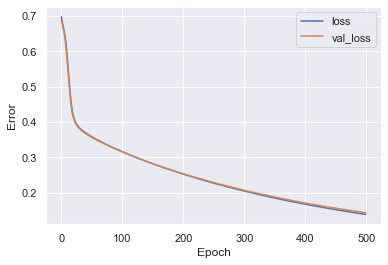

In [31]:
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def plot_loss(history):
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


#iteration  = iterations[0]
stratify   = 'false'
lrate      = 0.001
loss       = keras.losses.BinaryCrossentropy()
batch_size = 5000
                        
                        
model_layer = [
                  layers.Dense(64, activation='relu'),
                  layers.Dense(32, activation='relu'),
                  layers.Dense(16, activation='relu'),
                  layers.Dense(8, activation='relu'),
                  layers.Dense(2, activation='relu'),
                  layers.Dense(1, activation='sigmoid')
                ]
                        
def build_and_compile_model(model_layer, lrate, loss):

    model = keras.Sequential(model_layer)
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(lrate), metrics=METRICS)

    return model
                    

X_df = tdf[ [c for c in tdf.columns if c!='label'] ]
y_df = tdf[['label']]

train_X, test_X, train_y, test_y = train_test_split(X_df.values, y_df.values, test_size=0.3, random_state=21)


train_X = pd.DataFrame(train_X)
train_X.columns = X_df.columns

test_X = pd.DataFrame(test_X)
test_X.columns = X_df.columns

sc2   = MinMaxScaler()
train_X = pd.DataFrame( sc2.fit_transform(train_X) )
train_X.columns = X_df.columns

test_X = pd.DataFrame(  sc2.transform(test_X) )
test_X.columns = X_df.columns



model = build_and_compile_model(model_layer, lrate, loss)

history = model.fit(
                    train_X.values, train_y,
                    validation_split=0.3,
                    batch_size=batch_size,
                    verbose=1, epochs=500)

plot_loss(history)
plt.show()


In [32]:
model.evaluate(test_X, test_y)

240/240 [==============================] - 1s 2ms/step - loss: 0.1425 - tp: 3153.0000 - fp: 10.0000 - tn: 4503.0000 - fn: 0.0000e+00 - accuracy: 0.9987 - precision: 0.9968 - recall: 1.0000 - auc: 0.9999 - prc: 0.9997


[0.14245420694351196,
 3153.0,
 10.0,
 4503.0,
 0.0,
 0.9986955523490906,
 0.9968384504318237,
 1.0,
 0.9998878240585327,
 0.9996805191040039]

### Feature Imporance

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

model = GradientBoostingClassifier()
model.fit(train_X, train_y)
r = permutation_importance(model, train_X, train_y, n_repeats=30, random_state=0)

In [34]:
from sklearn.metrics import accuracy_score
y_test_pred = model.predict(test_X)

print(accuracy_score(y_test_pred, test_y))

0.9993477693712497


[Text(0, 0.0, 'revenue'),
 Text(0, 1.0, 'average_discount_onoffer'),
 Text(0, 2.0, 'afterpay_payments'),
 Text(0, 3.0, 'other_collection_orders'),
 Text(0, 4.0, 'home_orders'),
 Text(0, 5.0, 'days_since_last_order'),
 Text(0, 6.0, 'days_since_first_order'),
 Text(0, 7.0, 'is_newsletter_subscriber'),
 Text(0, 8.0, 'cc_payments')]

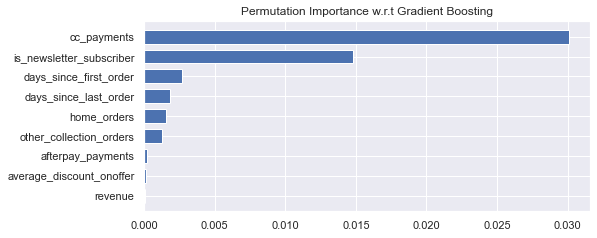

In [35]:
perm_sorted_idx = r.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_importance_sorted_idx = tree_importance_sorted_idx[-10:-1]
tree_indices = train_X.columns[tree_importance_sorted_idx]

fig, ax1 = plt.subplots(1, figsize=(8, 3.5))
ax1.set_title('Permutation Importance w.r.t Gradient Boosting')
ax1.barh(tree_indices, model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(train_X.columns[tree_importance_sorted_idx])

### Predicting for the entire dataset

In [36]:
edf = pd.read_csv('data/processed/encoded.csv')
tedf = edf[rdf.columns]
label = labelling_steps[3].predict(labelling_steps[1].predict(labelling_steps[0].transform(tedf.values)))

In [37]:
edf['label'] = label

In [38]:
edf.to_csv('predictoins_all.csv', index=False)

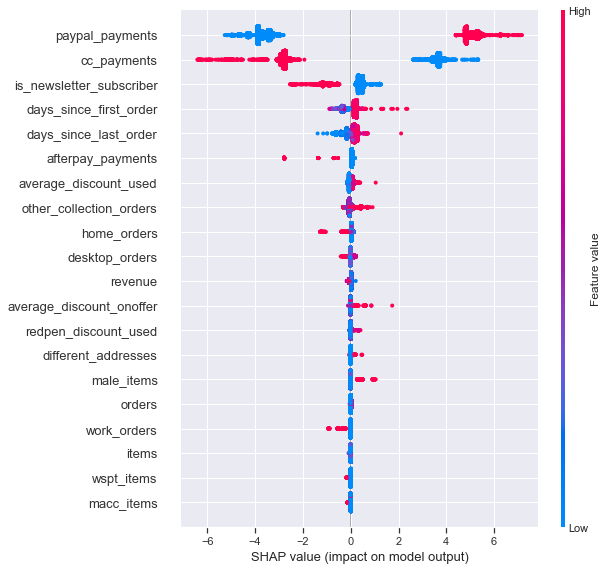

In [44]:
import shap
import importlib
import numpy
importlib.reload(numpy)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_X, approximate=False, check_additivity=False)

# train_X.columns
cols = train_X.columns

shap.summary_plot(shap_values, train_X, feature_names=cols)